In [33]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout, Dense, LSTM, CuDNNLSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, \
                                        accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
df_train = pd.read_csv('../data/train_cleaned.zip', compression='zip')
df_train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."


In [3]:
df_test = pd.read_csv('../data/test_cleaned.zip', compression='zip')
df_test.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,thank you for understanding i think very highl...,"['thank', 'you', 'for', 'understanding', 'i', ...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highli', 'wo...","[('thank', 'NN'), ('understanding', 'VBG'), ('...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highly', 'wo...","[('thank', 'understanding'), ('understanding',..."


In [4]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: str(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: str(x))

In [5]:
df_train['comment_text'][0], df_train['clean_text'][0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now')

In [6]:
#return dictionary with word: embedding_vector
def load_embedding(fname):
    embeddings_index = {}
    f = open(fname, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            embedding_vector = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = embedding_vector
    f.close()

    return embeddings_index

# Multi-label classification task
  toxic, severe_toxic, obscene, threat, insult, identity_hate

In [83]:
train_text = df_train.clean_text.values
test_text = df_test.clean_text.values

train_target = df_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values
test_target = df_test[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values

n_classes=train_target.shape[1]
max_words=75000
max_sequence_length=500
embedding_dims = 50
hidden_units=32

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(np.concatenate([train_text, test_text]))

#Train
train_sequences = tokenizer.texts_to_sequences(train_text) 
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

#Test
test_sequences = tokenizer.texts_to_sequences(test_text) 
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

word_index = tokenizer.word_index
embeddings_index = load_embedding("../glove.6B.50d.txt")
#embeddings_index = load_embedding("../wiki.simple.vec")

X_train, X_val, y_train, y_val = train_test_split(train_sequences, train_target, test_size=0.2, random_state=100)

In [87]:
model = Sequential()
embedding_matrix = np.random.random((len(word_index) + 1, embedding_dims))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model.add(Embedding(len(word_index) + 1,
                          embedding_dims,
                          weights=[embedding_matrix],
                          input_length=max_sequence_length,
                          trainable=True))

model.add(CuDNNLSTM(hidden_units))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='sigmoid'))

In [88]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),  tf.keras.metrics.Recall()]
)
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 500, 50)           15550050  
                                                                 
 cu_dnnlstm_30 (CuDNNLSTM)   (None, 32)                10752     
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 dense_22 (Dense)            (None, 6)                 390       
                                                                 
Total params: 15,563,304
Trainable params: 15,563,304
Non-trainable params: 0
_________________________________________________________________


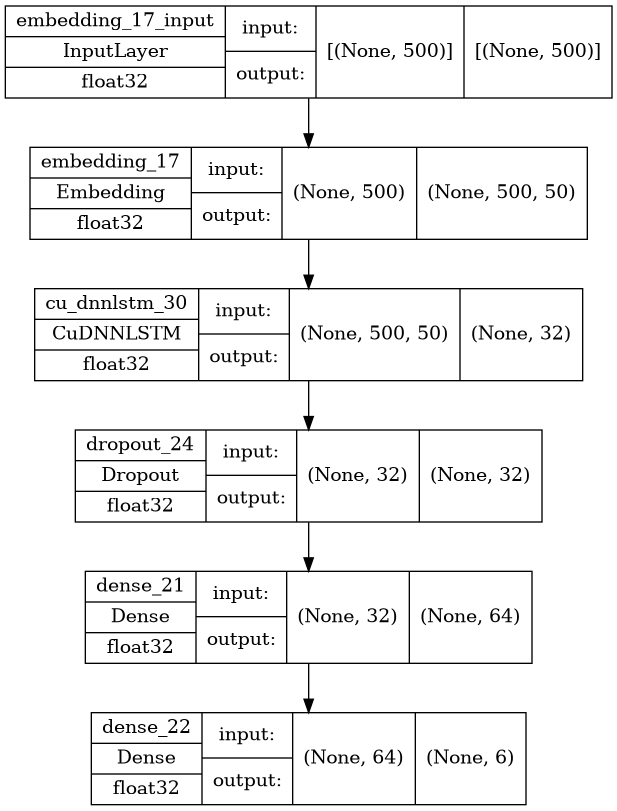

In [89]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [90]:
epochs = 10
batch_size=32

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=es)

Epoch 1/10
3990/3990 [==============================] - 141s 35ms/step - loss: 0.0729 - auc_10: 0.9562 - precision_10: 0.7333 - recall_10: 0.5181 - val_loss: 0.0529 - val_auc_10: 0.9795 - val_precision_10: 0.7951 - val_recall_10: 0.6285
Epoch 2/10
3990/3990 [==============================] - 140s 35ms/step - loss: 0.0508 - auc_10: 0.9797 - precision_10: 0.8091 - recall_10: 0.6454 - val_loss: 0.0490 - val_auc_10: 0.9820 - val_precision_10: 0.7739 - val_recall_10: 0.6878
Epoch 3/10
3990/3990 [==============================] - 140s 35ms/step - loss: 0.0440 - auc_10: 0.9855 - precision_10: 0.8224 - recall_10: 0.6925 - val_loss: 0.0479 - val_auc_10: 0.9818 - val_precision_10: 0.7915 - val_recall_10: 0.6733
Epoch 4/10
3990/3990 [==============================] - 140s 35ms/step - loss: 0.0395 - auc_10: 0.9888 - precision_10: 0.8264 - recall_10: 0.7264 - val_loss: 0.0490 - val_auc_10: 0.9771 - val_precision_10: 0.8010 - val_recall_10: 0.6614
Epoch 5/10
3990/3990 [==============================

In [91]:
history.history

{'loss': [0.07286199927330017,
  0.05079648643732071,
  0.04397512599825859,
  0.03945762664079666,
  0.03534034267067909,
  0.0321972519159317,
  0.02964775450527668,
  0.027875900268554688],
 'auc_10': [0.9562026858329773,
  0.9796716570854187,
  0.9854774475097656,
  0.988786518573761,
  0.9912781119346619,
  0.9929940104484558,
  0.9938645362854004,
  0.9945527911186218],
 'precision_10': [0.7333232760429382,
  0.8091282844543457,
  0.822446882724762,
  0.8263635635375977,
  0.8363969922065735,
  0.8451671600341797,
  0.8548700213432312,
  0.8629274368286133],
 'recall_10': [0.5180778503417969,
  0.6453887820243835,
  0.6925159692764282,
  0.7264275550842285,
  0.7634025812149048,
  0.7933245301246643,
  0.8153741955757141,
  0.8297296166419983],
 'val_loss': [0.05287811532616615,
  0.049000050872564316,
  0.047864072024822235,
  0.049031756818294525,
  0.05139775574207306,
  0.055062901228666306,
  0.05626693740487099,
  0.06648369878530502],
 'val_auc_10': [0.9794656038284302,
  

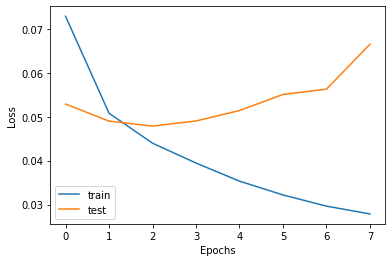

In [94]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

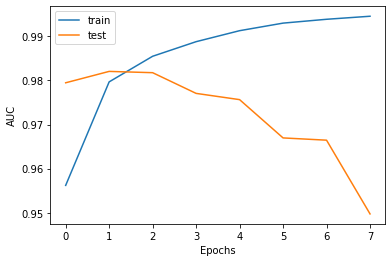

In [98]:
plt.plot(history.history['auc_10'], label='train')
plt.plot(history.history['val_auc_10'], label='test')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

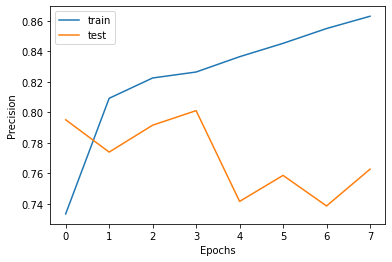

In [99]:
plt.plot(history.history['precision_10'], label='train')
plt.plot(history.history['val_precision_10'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

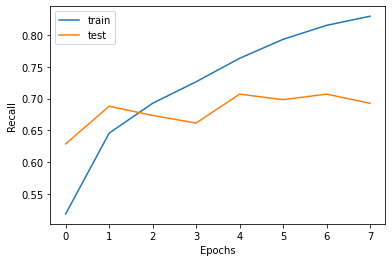

In [100]:
plt.plot(history.history['recall_10'], label='train')
plt.plot(history.history['val_recall_10'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [92]:
y_prob = model.predict(X_test)
y_pred = y_prob.round()

In [93]:
print(classification_report(test_target, y_pred, target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate']))
multilabel_confusion_matrix(test_target, y_pred)

               precision    recall  f1-score   support

        toxic       0.51      0.84      0.63      6090
 severe_toxic       0.32      0.50      0.39       367
      obscene       0.62      0.76      0.68      3691
       threat       0.00      0.00      0.00       211
       insult       0.64      0.62      0.63      3427
identity_hate       0.64      0.40      0.49       712

    micro avg       0.56      0.72      0.63     14498
    macro avg       0.45      0.52      0.47     14498
 weighted avg       0.56      0.72      0.62     14498
  samples avg       0.07      0.07      0.07     14498



array([[[53026,  4862],
        [  998,  5092]],

       [[63218,   393],
        [  183,   184]],

       [[58561,  1726],
        [  900,  2791]],

       [[63765,     2],
        [  211,     0]],

       [[59344,  1207],
        [ 1311,  2116]],

       [[63102,   164],
        [  425,   287]]])

In [101]:
print(f'Accuracy score: {accuracy_score(test_target, y_pred)}')

Accuracy score: 0.8623433055112695


In [104]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_target[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [105]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_target.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [106]:
print(roc_auc["micro"])

0.9721557487610011


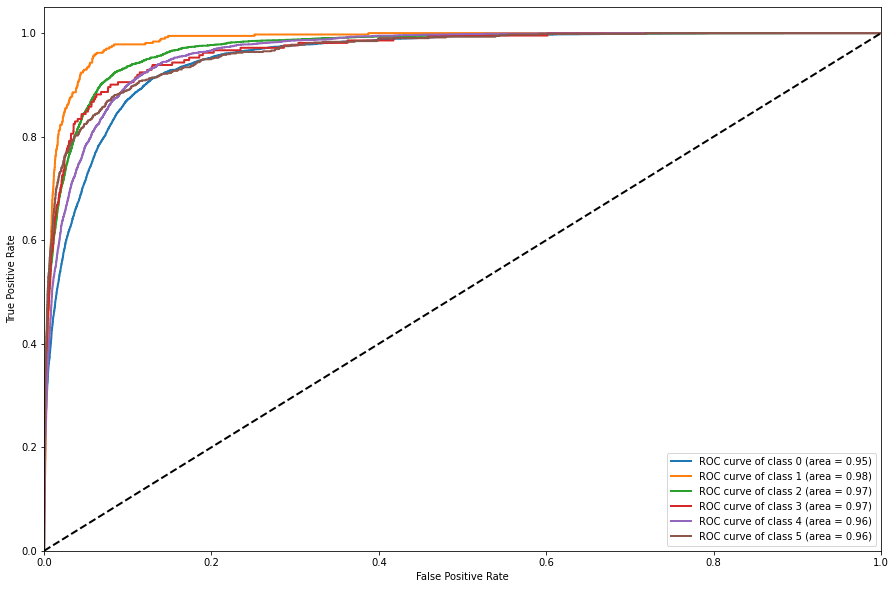

In [107]:
plt.figure(figsize=(15,10))
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()